In [ ]:
# !pip install yfinance
# !pip install matplotlib
# !pip install statsmodels
# !pip install scikit-learn
# import sys
# print(sys.executable)

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.7 MB 3.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/10.7 MB 3.0 MB/s eta 0:00:04
   ----- ---------------------------------- 1.6/10.7 MB 2.9 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/10.7 MB 2.9 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/10.7 MB 2.8 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/10.7 MB 2.8 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/10.7 MB 2.9 MB/s eta 0:00:03
   ---------------- ----------------------- 4.5/10.7 MB 2.7 MB/s eta 0:00:03
   ------------------ --------------------- 5.0/10.7 MB 2.7 MB/s eta 0:00:03
   --------------------- ------------------ 5.8/10.7 MB 2.8 MB/s eta 0:00:02
   ----------------------- ---------------- 6.3/10.7 MB 2.8 MB/s eta 0:00:02
   -----------

In [ ]:
# msft.info
# msft.calendar
# msft.analyst_price_targets
# msft.quarterly_income_stmt
# msft.history(period='1mo')
# msft.option_chain(msft.options[0]).calls

# Data Acqusition & Preprocessing

In [56]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [9]:
# retrieving historical data for Microsoft (MSFT) stock
# for the last 60 days with a 5-minute interval
msft = yf.Ticker("MSFT")
msft_df = msft.history(
    period="60d", 
    interval="5m",
)

print(msft_df.head())

                                 Open        High         Low       Close  \
Datetime                                                                    
2025-03-17 09:30:00-04:00  386.769989  388.829987  385.929993  388.730011   
2025-03-17 09:35:00-04:00  388.730011  389.670013  388.260010  389.574402   
2025-03-17 09:40:00-04:00  389.589996  389.929993  388.959991  389.035004   
2025-03-17 09:45:00-04:00  389.089996  389.299988  388.355011  388.429993   
2025-03-17 09:50:00-04:00  388.415009  389.219910  388.020111  388.959991   

                           Volume  Dividends  Stock Splits  
Datetime                                                    
2025-03-17 09:30:00-04:00  826135        0.0           0.0  
2025-03-17 09:35:00-04:00  347415        0.0           0.0  
2025-03-17 09:40:00-04:00  286601        0.0           0.0  
2025-03-17 09:45:00-04:00  241477        0.0           0.0  
2025-03-17 09:50:00-04:00  176949        0.0           0.0  


In [ ]:
# msft_df.loc['2025-03-07']
# msft_df.loc['2025-06-09']
# msft_df.info()
# msft_df.describe()
# msft_df.isnull().sum()
# msft_df.isnull().values.any()
# print(msft_df[msft_df[msft_df.isnull().any(axis=1)]])
# print(msft_df[msft_df.duplicated()])

<bound method DataFrame.isna of Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Dividends, Stock Splits]
Index: []>

*Because of the nature of stock markets being closed on weekend, there is a gap for those specific dates. Arima handles this with sequential indexing instead of needing to fill with artifical values for regular time intervals.*

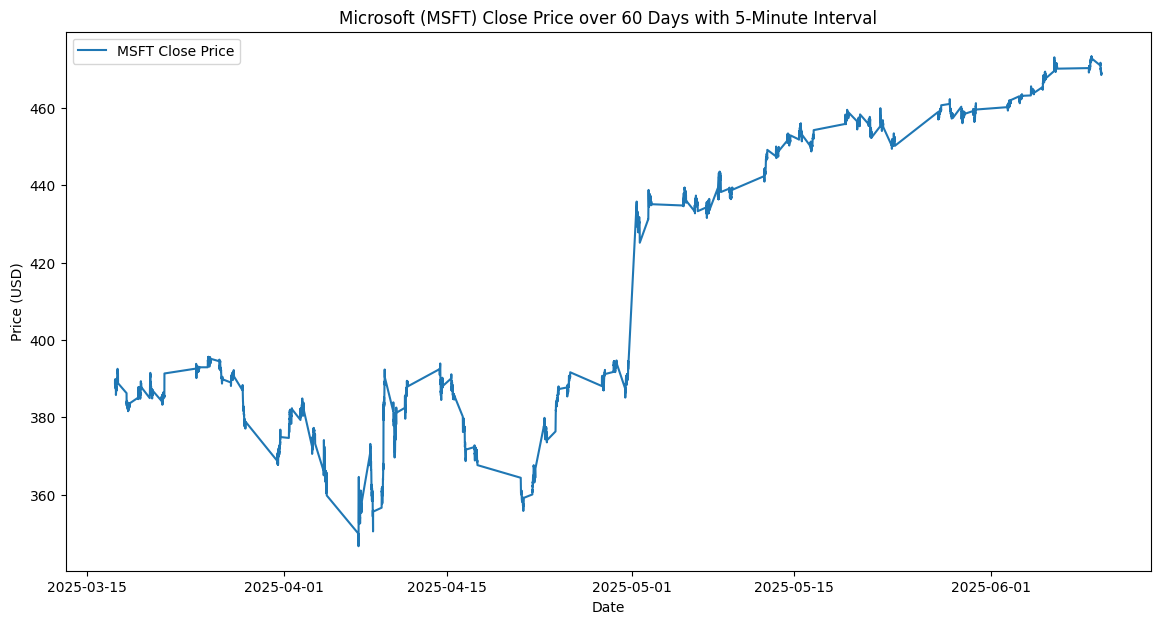

In [53]:
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close'], label='MSFT Close Price')
plt.title('Microsoft (MSFT) Close Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

### Checking for stationarity (statistical properties are constant) 

* Null Hypothesis: Series is not stationary (there is a trend, changing/mean variance, or other non stationary).
* Alternative hypothesis: Series is stationary.

In [ ]:
result = adfuller(msft_df["Close"])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] < 0.05:    
    print("Interpretation: The original series is Stationary.")
else:    
    print("Interpretation: The original series is Non-Stationary.")

ADF Statistic: -0.4430
p-value: 0.9027
Interpretation: The original series is Non-Stationary.



In [50]:
msft_df['Close_Diff'] = msft_df['Close'].diff()
result_diff = adfuller(msft_df["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:    
    print("Interpretation: The differenced series is Stationary.")
else:    
    print("Interpretation: The differenced series is Non-Stationary.")


ADF Statistic (Differenced): -48.1720
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


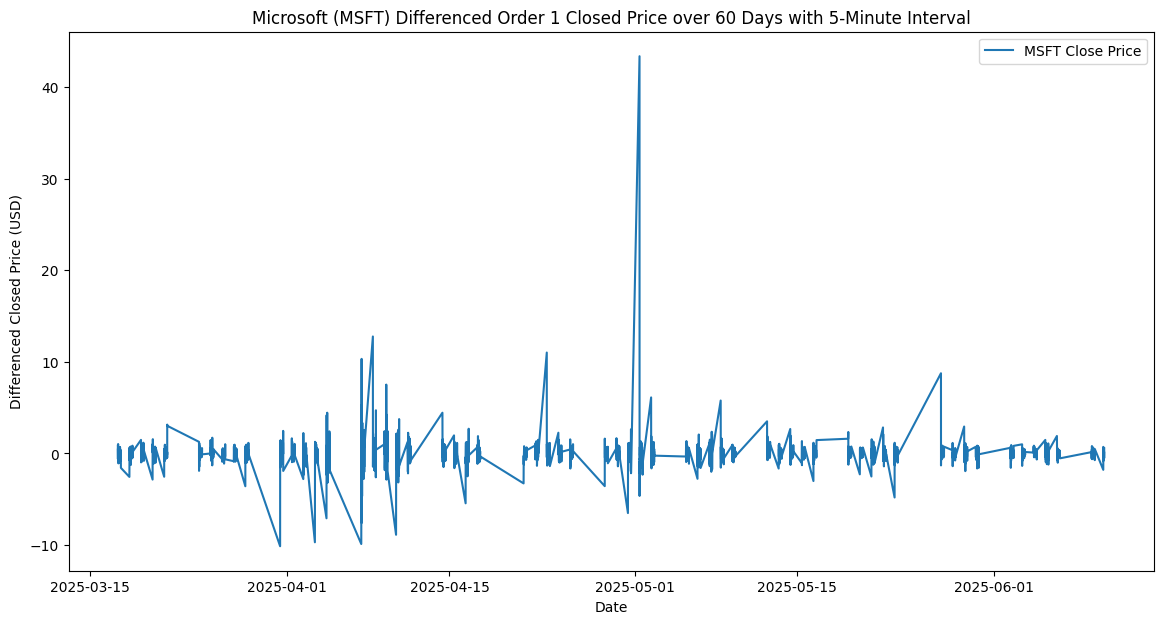

In [124]:
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close_Diff'], label='MSFT Close Price')
plt.title('Microsoft (MSFT) Differenced Order 1 Closed Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Differenced Closed Price (USD)')
plt.legend()

In [150]:
max_diff_val = msft_df['Close_Diff'].abs().max()
spiked_date = msft_df.loc[msft_df['Close_Diff'].abs() == max_diff_val]
spiked_date['Close']

Datetime
2025-05-01 09:30:00-04:00    435.779999
Name: Close, dtype: float64

In [151]:
end_date = '2025-04-03 15:55:00-04:00'
msft_df.loc[end_date]

Open            3.742800e+02
High            3.743100e+02
Low             3.726100e+02
Close           3.731200e+02
Volume          1.656480e+06
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Close_Diff     -1.130005e+00
Close_Diff2    -1.024994e+00
Name: 2025-04-03 15:55:00-04:00, dtype: float64

#### Outlier is due to a spike in stock price due to a positive  quarterly earnings report

In [123]:
msft_df['Close_Diff2'] = msft_df['Close_Diff'].diff()
result_diff = adfuller(msft_df["Close_Diff2"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:    
    print("Interpretation: The differenced series is Stationary.")
else:    
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Differenced): -22.0081
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


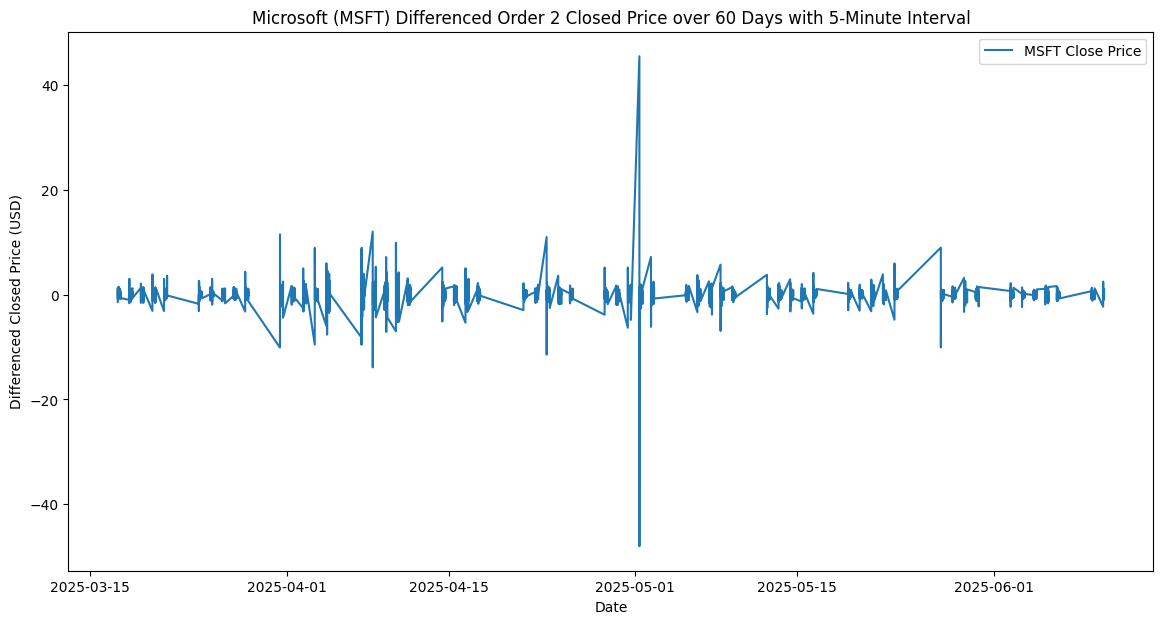

In [125]:
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close_Diff2'], label='MSFT Close Price')
plt.title('Microsoft (MSFT) Differenced Order 2 Closed Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Differenced Closed Price (USD)')
plt.legend()

In [ ]:
# # calculating auto correlation for a lag of 1
# X = np.array([100, 102, 105, 107, 109])
# mean_X = np.mean(X)
# deviations = X - mean_X
# print(deviations)
# lagged_deviations = np.roll(deviations, shift=1)
# lagged_deviations[0] = 0 
# print(lagged_deviations)
# autocorrelation = np.sum(deviations * lagged_deviations) / np.sum(deviations ** 2)
# print("Autocorrelation at lag 1:", autocorrelation)

[-4.6 -2.6  0.4  2.4  4.4]
[ 0.  -4.6 -2.6  0.4  2.4]
Autocorrelation at lag 1: 0.42180451127819546


#### Arima Parameters:
* p(Autoregressive Order): the number of lagged observations
* d(Differencing Order): refers to the order of differencing
* q(Moving Average Order): the number of lagged forecast errors included in the model

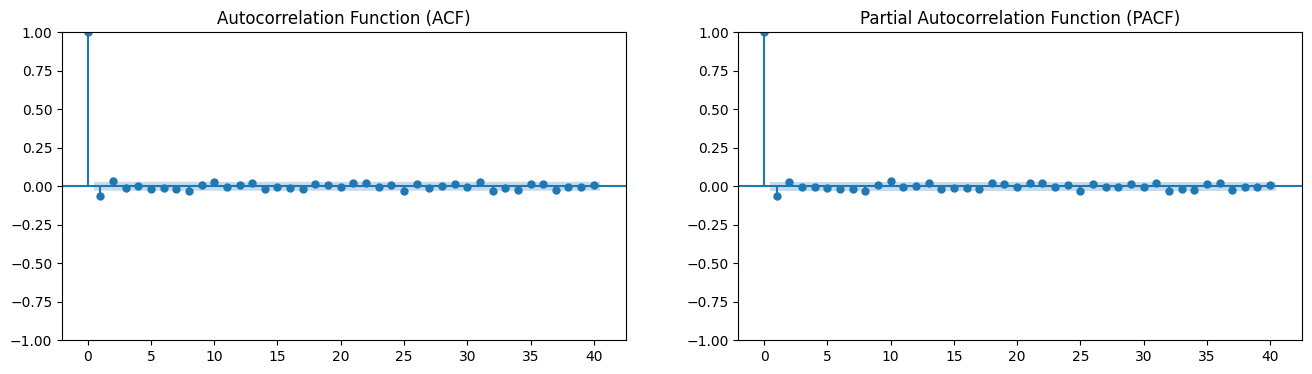

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(msft_df['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(msft_df['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()

* ACF Lag 1 Spike
* PACF Lag 1 Spike
* We have a strong correlation with immediate past values; so, we'll use 1 for AR and MA. And we've already used 1.

In [157]:
msft_df.iloc[:train_size]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_Diff,Close_Diff2
Datetime,,,,,,,,,
2025-03-17 09:30:00-04:00,386.769989,388.829987,385.929993,388.730011,826135,0.0,0.0,NaN,NaN
2025-03-17 09:35:00-04:00,388.730011,389.670013,388.260010,389.574402,347415,0.0,0.0,0.844391,NaN
2025-03-17 09:40:00-04:00,389.589996,389.929993,388.959991,389.035004,286601,0.0,0.0,-0.539398,-1.383789
2025-03-17 09:45:00-04:00,389.089996,389.299988,388.355011,388.429993,241477,0.0,0.0,-0.605011,-0.065613
2025-03-17 09:50:00-04:00,388.415009,389.219910,388.020111,388.959991,176949,0.0,0.0,0.529999,1.135010
...,...,...,...,...,...,...,...,...,...
2025-05-22 12:00:00-04:00,456.170013,456.549988,456.070801,456.184998,86852,0.0,0.0,0.024994,-0.355011
2025-05-22 12:05:00-04:00,456.220001,456.549988,455.880005,456.301392,82503,0.0,0.0,0.116394,0.091400
2025-05-22 12:10:00-04:00,456.299988,456.630005,456.059601,456.359985,172136,0.0,0.0,0.058594,-0.057800


In [156]:
train_size = int(len(msft_df) * 0.8)
train, test = msft_df.iloc[:train_size], msft_df.iloc[train_size:]
arima_model = ARIMA(train["Close"], order=(1,1,1))
arima_fit = arima_model.fit()

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The .fit() method for the ARIMA model estimates (learns) the best parameters for the ARIMA model using your training data. It finds the coefficients for the autoregressive, differencing, and moving average terms that best explain the patterns in your data.

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


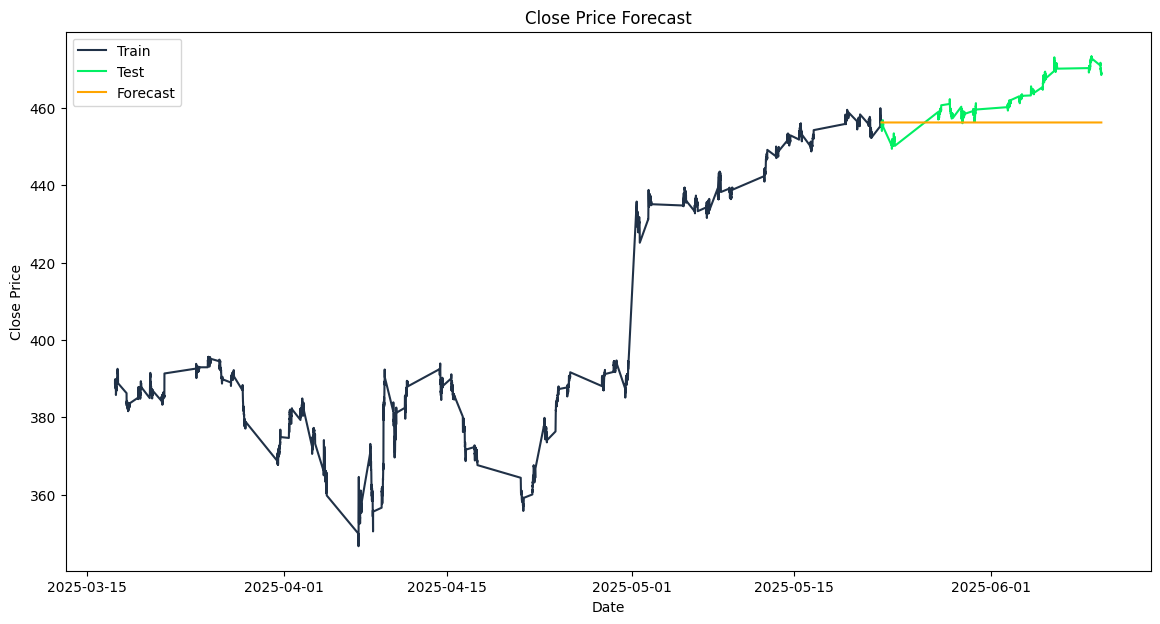

In [163]:
forecast = arima_fit.forecast(steps=len(test))
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [189]:
print(f"AIC: {arima_fit.aic}")
print(f"BIC: {arima_fit.bic}")
print(f"On average, our model's predictions deviate from the actual by: {mean_squared_error(test['Close'], forecast)}")

AIC: 11484.563415288734
BIC: 11503.210868664231
On average, our model's predictions deviate from the actual by: 68.69150848977576


In [ ]:
# actual = test["Close"][:len(forecast)]
# actual2 = test["Close"]
# (actual == actual2).any()

np.True_

# Feature Engineering